# **DBSCAN Clustering for Banking Clients (Fixed Version)**

This notebook applies **DBSCAN clustering** on a **banking client dataset**, using **Gower distance** to handle mixed numerical & categorical data. 

### **🔹 Pipeline Overview:**
1. **Load & Preprocess Data** (Handling categorical & numerical features)
2. **Compute Gower Distance** (for mixed numerical & categorical data)
3. **Find Optimal `eps`** Using a K-Distance Graph (Elbow Method)
4. **Auto-Tune DBSCAN** to find a balanced number of clusters
5. **Evaluate Clustering Performance** (Silhouette, Davies-Bouldin, Calinski-Harabasz Scores)
6. **Visualize Results using t-SNE in 3D**
7. **Interpret the Clusters** (Restoring numerical values & categorical labels)


In [4]:
import pandas as pd
import numpy as np

# Load dataset (Update path if necessary)
path = '/Users/mouadh/Fintech_Projects/Business_Case_1/data/Dataset1_BankClients.xlsx'
data = pd.read_excel(path)

# Drop ID column if present
if 'ID' in data.columns:
    data = data.drop(columns=['ID'])

# Display first 5 rows
data.head()


,Age,Gender,Job,Area,CitySize,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Investments
0,24,1,1,2,2,4,0.668046,0.702786,0.262070,0.741853,0.483684,0.698625,0.618259,0.607877,0.897369,0.283222,1
1,47,1,2,2,3,1,0.858453,0.915043,0.730430,0.859423,0.537167,0.959025,0.785936,0.862271,0.913729,0.821590,3
2,38,0,2,1,2,2,0.926818,0.898316,0.441272,0.485953,0.649434,0.750265,0.699725,0.755404,0.765199,0.503790,3
3,67,0,2,1,2,3,0.538797,0.423180,0.600401,0.493144,0.533829,0.590165,0.675353,0.334432,0.517209,0.691240,2
4,33,0,2,1,3,1,0.806659,0.731404,0.831449,0.856286,0.784940,0.710026,0.758793,0.908878,0.611610,0.615916,2


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA

# Define categorical columns
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']

# Separate numerical & categorical features
numerical_features = data.drop(columns=categorical_columns)
categorical_features = data[categorical_columns]

## **🔹 1. Correlation Heatmap**
# Compute correlation matrix for numerical features (Pearson correlation)
corr_matrix = numerical_features.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
plt.title("Numerical Feature Correlation Heatmap")
plt.show()

## **🔹 2. Pairplot (Scatterplot Matrix)**
sns.pairplot(numerical_features, diag_kind='kde')
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()

## **🔹 3. Distribution of Features (Histograms & KDE)**
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_features.columns[:6]):  # Limit to first 6 features
    sns.histplot(numerical_features[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

## **🔹 4. Boxplots for Outlier Detection**
plt.figure(figsize=(12, 6))
sns.boxplot(data=numerical_features)
plt.xticks(rotation=90)
plt.title("Boxplots for Numerical Features (Outlier Detection)")
plt.show()

## **🔹 5. PCA Variance Explained (Dimensionality Reduction Insight)**
scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(numerical_features)

pca = PCA()
pca.fit(X_num_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance by Number of Components")
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Threshold")
plt.legend()
plt.grid()
plt.show()

# Identify highly correlated numerical feature pairs (Threshold: 0.85)
high_corr_pairs = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            high_corr_pairs.add((corr_matrix.columns[i], corr_matrix.columns[j]))

print("🔹 Highly Correlated Numerical Feature Pairs (Correlation > 0.85):")
features_to_drop = []
for pair in high_corr_pairs:
    print(f"⚠️ {pair[0]} ↔ {pair[1]} (Correlation: {corr_matrix.loc[pair[0], pair[1]]:.2f})")
    features_to_drop.append(pair[1])  # Drop the second feature in each pair

# Drop redundant numerical features
numerical_features_reduced = numerical_features.drop(columns=set(features_to_drop))
print(f"✅ Adjusted Numerical Features Shape: {numerical_features_reduced.shape}")

# Scale reduced numerical features
X_num_scaled = scaler.fit_transform(numerical_features_reduced)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(categorical_features)

# Concatenate processed numerical & categorical features
X_preprocessed = np.concatenate((X_num_scaled, X_cat_encoded), axis=1)

# Get updated feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
all_feature_names = numerical_features_reduced.columns.tolist() + encoded_feature_names.tolist()

# Check final shape
print(f'Processed Data Shape After Correlation Filtering: {X_preprocessed.shape}')

Processed Data Shape: (5000, 28)


In [20]:
import gower

# Compute Gower Distance Matrix
gower_distances = gower.gower_matrix(X_preprocessed)

# Display first 5 rows
gower_distances[:5, :5]


array([[0.        , 0.3308228 , 0.3688255 , 0.3962298 , 0.46500587],
       [0.3308228 , 0.        , 0.28962833, 0.4133628 , 0.27291024],
       [0.3688255 , 0.28962833, 0.        , 0.17167616, 0.21496232],
       [0.3962298 , 0.4133628 , 0.17167616, 0.        , 0.18863821],
       [0.46500587, 0.27291024, 0.21496232, 0.18863821, 0.        ]],
      dtype=float32)

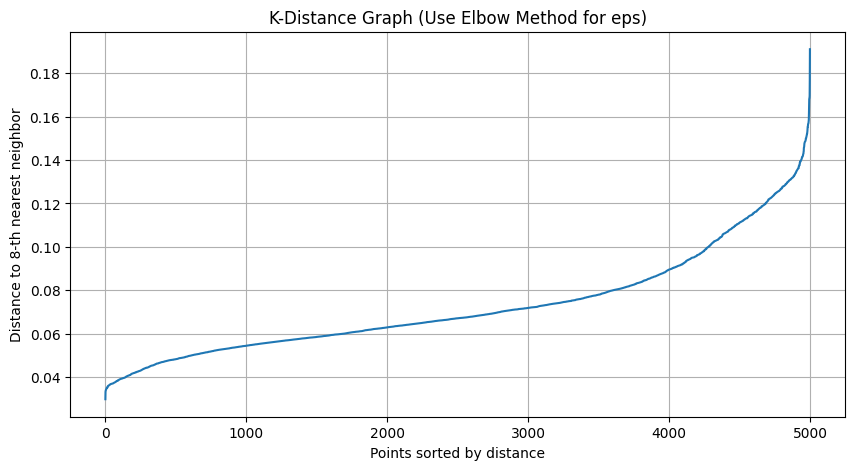

🔹 Trying eps at 90th percentile: 0.1111


In [21]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Function to find optimal eps using k-distance graph
def find_optimal_eps(distance_matrix, k=8, percentile_range=(90, 98)):
    nbrs = NearestNeighbors(n_neighbors=k, metric='precomputed').fit(distance_matrix)
    distances, indices = nbrs.kneighbors(distance_matrix)

    sorted_distances = np.sort(distances[:, -1], axis=0)

    # Plot k-distance graph
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"Distance to {k}-th nearest neighbor")
    plt.title("K-Distance Graph (Use Elbow Method for eps)")
    plt.grid(True)
    plt.show()

    for p in range(percentile_range[0], percentile_range[1] + 1, 2):
        test_eps = np.percentile(sorted_distances, p)
        print(f"🔹 Trying eps at {p}th percentile: {test_eps:.4f}")
        if 0.05 <= test_eps <= 0.2:
            return test_eps

    return np.percentile(sorted_distances, 95)

# Automatically determine initial eps
optimal_eps = find_optimal_eps(gower_distances, k=8, percentile_range=(90, 98))


In [29]:
from sklearn.cluster import DBSCAN
import numpy as np

# Dynamically choose min_samples (allow flexibility)
min_samples_range = (3, 12)  # Allow smaller clusters
optimal_min_samples = max(int(np.log(len(gower_distances))), min_samples_range[0])
optimal_min_samples = min(optimal_min_samples, min_samples_range[1])

print(f"✅ Initial min_samples: {optimal_min_samples}")

# Iterative DBSCAN adjustment
increment_factor = 1.05
max_iterations = 7
target_clusters = (4, 10)

for i in range(max_iterations):
    dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples, metric='precomputed')
    labels_dbscan = dbscan.fit_predict(gower_distances)

    unique_clusters = np.unique(labels_dbscan)
    num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    num_noise = sum(labels_dbscan == -1)

    print(f"Iteration {i+1}: eps={optimal_eps:.4f} → {num_clusters} clusters, {num_noise} noise points")

    # Stop if cluster count is in a good range
    if target_clusters[0] <= num_clusters <= target_clusters[1]:
        break

    # If too many noise points, increase `eps`
    if num_noise > len(gower_distances) * 0.20:
        optimal_eps *= 1.05  # Increase to include more points

    # If too few clusters, reduce `min_samples`
    elif num_clusters < target_clusters[0]:
        optimal_min_samples = max(optimal_min_samples - 1, min_samples_range[0])

    # If too many clusters, slightly reduce `eps`
    elif num_clusters > target_clusters[1]:
        optimal_eps *= 0.95

print(f"✅ Final eps selected: {optimal_eps:.4f}")
print(f"✅ Final min_samples: {optimal_min_samples}")
print(f"✅ Final clusters: {num_clusters}")
print(f"✅ Final noise points: {num_noise}")


✅ Initial min_samples: 8
Iteration 1: eps=0.1111 → 2 clusters, 222 noise points
Iteration 2: eps=0.1111 → 2 clusters, 183 noise points
Iteration 3: eps=0.1111 → 4 clusters, 140 noise points
✅ Final eps selected: 0.1111
✅ Final min_samples: 6
✅ Final clusters: 4
✅ Final noise points: 140


In [30]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

if num_clusters > 1:
    ch_score = calinski_harabasz_score(X_preprocessed, labels_dbscan)
    db_score = davies_bouldin_score(X_preprocessed, labels_dbscan)
    sil_score = silhouette_score(gower_distances, labels_dbscan, metric='precomputed')

    print("🔹 **Cluster Evaluation Metrics**:")
    print(f"✅ **Calinski-Harabasz Score:** {ch_score:.4f} (Higher = Better)")
    print(f"✅ **Davies-Bouldin Score:** {db_score:.4f} (Lower = Better)")
    print(f"✅ **Silhouette Score:** {sil_score:.4f} (Closer to 1 = Better)")
else:
    print("⚠️ Not enough clusters detected for evaluation.")


🔹 **Cluster Evaluation Metrics**:
✅ **Calinski-Harabasz Score:** 16.7852 (Higher = Better)
✅ **Davies-Bouldin Score:** 2.1996 (Lower = Better)
✅ **Silhouette Score:** -0.0717 (Closer to 1 = Better)


In [31]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import pandas as pd

# Compute 3D t-SNE projection (Fixing the init='pca' issue)
tsne = TSNE(n_components=3, metric='precomputed', init='random', random_state=42)
X_tsne_3d = tsne.fit_transform(gower_distances)

# Create DataFrame for visualization
df_plot = pd.DataFrame({'x': X_tsne_3d[:, 0], 'y': X_tsne_3d[:, 1], 'z': X_tsne_3d[:, 2], 'Cluster': labels_dbscan})

# Generate interactive 3D scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=df_plot['x'],
    y=df_plot['y'],
    z=df_plot['z'],
    mode='markers',
    marker=dict(
        size=5,  # Adjust this value to control marker size
        color=df_plot['Cluster'],  # Color by cluster
        colorscale='Turbo',  # Set color scale
        opacity=0.7  # Adjust transparency
    )
))

# Customize layout
fig.update_layout(
    title="3D t-SNE Cluster Visualization (DBSCAN)",
    scene=dict(
        xaxis_title="t-SNE 1",
        yaxis_title="t-SNE 2",
        zaxis_title="t-SNE 3",
        aspectmode="cube"  # Keeps the aspect ratio balanced
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=800,  # Adjusted figure width
    height=800   # Adjusted figure height
)

fig.show()

In [32]:
# Convert back to DataFrame with proper labels
cluster_summary = pd.DataFrame(X_preprocessed, columns=all_feature_names)
cluster_summary['Cluster'] = labels_dbscan

# Compute mean of each feature per cluster (excluding noise points)
valid_clusters = cluster_summary[cluster_summary['Cluster'] != -1]
summary = valid_clusters.groupby('Cluster').mean()

# Reverse MinMax scaling to restore original numerical values
summary_original_scale = summary.copy()
summary_original_scale[numerical_features.columns] = scaler.inverse_transform(summary[numerical_features.columns])

# Restore categorical feature labels
for cat_col in categorical_columns:
    one_hot_columns = [col for col in summary_original_scale.columns if col.startswith(cat_col + "_")]
    summary_original_scale[cat_col] = summary_original_scale[one_hot_columns].idxmax(axis=1).str.split('_').str[1]
    summary_original_scale = summary_original_scale.drop(columns=one_hot_columns)

# Display final cluster characteristics
from IPython.display import display
print("🔹 **Cluster Characteristics (Original Scale & Categorical Labels Restored):**")
display(summary_original_scale)


🔹 **Cluster Characteristics (Original Scale & Categorical Labels Restored):**


,Age,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Gender,Job,Area,CitySize,Investments
Cluster,,,,,,,,,,,,,,,,,
0,60.598389,2.489573,0.576663,0.580500,0.431882,0.512336,0.588191,0.527524,0.619740,0.462168,0.475526,0.523348,1,2,1,2,3
1,63.200000,3.000000,0.339124,0.450588,0.170010,0.406711,0.577936,0.509174,0.563131,0.302570,0.342687,0.299231,0,5,2,1,3
2,88.750000,2.250000,0.358225,0.329393,0.106643,0.368870,0.566573,0.190440,0.734485,0.368459,0.182373,0.300226,0,5,2,3,3
3,41.250000,1.250000,0.472684,0.481071,0.426790,0.448523,0.638255,0.590320,0.476052,0.477648,0.401929,0.477657,1,4,1,2,2
